#### 数据集：Zachary‘s karate club network
图只有1个

每一个点有34维度特征

对每一个点做4分类


In [1]:
from torch_geometric.datasets import KarateClub

from GNN.Pyg_demo_0 import edge_index
from torch_geometric.visualization import visualize_graph

dataset = KarateClub()
print(f'Dataset: {dataset}')
print('================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [2]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


34x34====>M*F

M为样本个数，F为特征维度

一共有156的点，从source到target映射

y为标签

train_mask主要用于计算损失，能够标记有标签的点

In [3]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

前一个为0~34号点，后一位为该点与哪些点有关系

index稀疏表示的，并不是一个n*n的邻接矩阵

#### 画图的主模块

In [8]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graphs(g, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(g, pos=nx.spring_layout(g, seed=42), with_labels=False, node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], c=color, s=1, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch}, loss:{loss.item():.4f}', fontsize=16)
    plt.show()

#### 使用networkx可视化展示

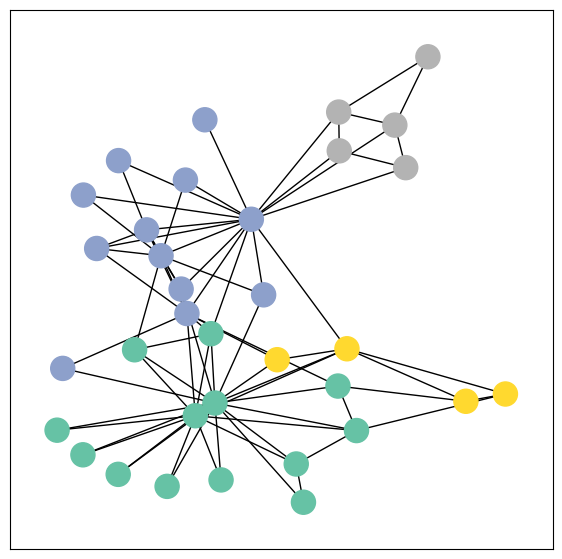

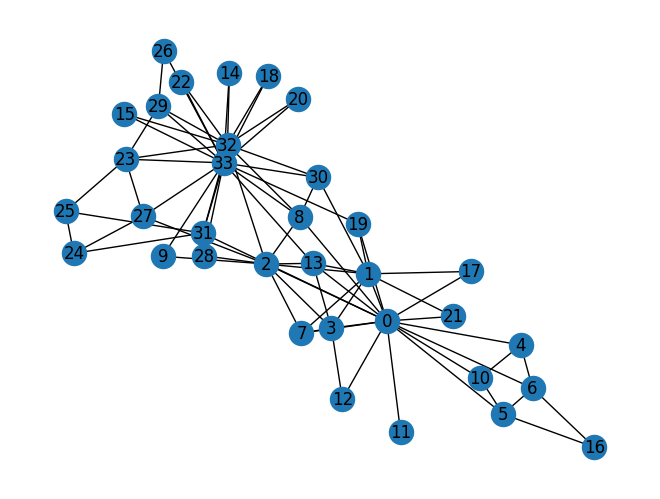

In [16]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graphs(G, color=data.y)
# 也可以用nx自带的来画图
nx.draw(G, with_labels=G.nodes)
plt.show()

#### GCN网络定义